<a href="https://colab.research.google.com/github/Hyeonvidia/CUSTOMISED-DETECTION/blob/main/download_roboflow_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required packages
%pip install roboflow opencv-python matplotlib pyyaml

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import glob
import random
import yaml
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
from roboflow import Roboflow

# Display plots inline in Jupyter
%matplotlib inline


In [ ]:
# Initialize Roboflow and download the dataset
rf = Roboflow(api_key="UK7i4oOIag6270PB4zKU")
project = rf.workspace("vestellalab-5zuxg").project("ax-device")
version = project.version(2)
dataset = version.download("yolov9")

print(f"✅ Download complete. Location: {dataset.location}")


loading Roboflow workspace...
loading Roboflow project...
✅ Download complete. Location: /Users/hyeonvidia/Project/AX-Device-2


In [ ]:
def load_data_yaml(yaml_path):
    """Parses the data.yaml file and returns the dictionary and root path."""
    path = Path(yaml_path).resolve()
    with open(path, "r", encoding="utf-8") as f:
        data = yaml.safe_load(f)
    return data, path.parent

def resolve_path(path_entry, root_dir):
    """Resolves relative paths from the yaml file to absolute paths."""
    p = Path(path_entry)
    if not p.is_absolute():
        p = (root_dir / p).resolve()
    return p

def infer_label_path(image_path):
    """
    Attempts to find the corresponding label file for an image.
    Standard YOLO structure: /images/train/img.jpg -> /labels/train/img.txt
    """
    image_path = Path(image_path)

    # Strategy 1: Replace 'images' in path with 'labels'
    parts = list(image_path.parts)
    if "images" in parts:
        # Find the last occurrence of 'images' to support nested paths
        idx = len(parts) - 1 - parts[::-1].index("images")
        parts[idx] = "labels"
        label_path = Path(*parts).with_suffix(".txt")
        if label_path.exists():
            return label_path

    # Strategy 2: Check for a sibling 'labels' folder
    sibling_label = image_path.parent.parent / "labels" / image_path.with_suffix(".txt").name
    if sibling_label.exists():
        return sibling_label

    return None

def load_yolo_labels(label_path):
    """Reads YOLO format txt file: class_id cx cy w h"""
    boxes = []
    try:
        with open(label_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 5:
                    cls_id = int(parts[0])
                    coords = list(map(float, parts[1:]))
                    boxes.append((cls_id, coords))
    except Exception:
        pass
    return boxes


In [ ]:
def plot_images(pairs, class_names, split_name):
    """Plots images with bounding boxes using Matplotlib."""
    if not pairs:
        print(f"⚠️ No valid pairs found for {split_name}")
        return

    count = len(pairs)
    # Create subplots dynamically
    fig, axes = plt.subplots(1, count, figsize=(5 * count, 5))
    if count == 1: axes = [axes]

    print(f"   -> Showing {count} samples for '{split_name}'...")

    for ax, (img_path, lbl_path) in zip(axes, pairs):
        img = cv2.imread(str(img_path))
        if img is None: continue

        # Convert BGR (OpenCV) to RGB (Matplotlib)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h_img, w_img, _ = img.shape

        ax.imshow(img)
        ax.axis("off")
        ax.set_title(img_path.name, fontsize=10)

        # Draw Boxes
        boxes = load_yolo_labels(lbl_path)
        for cls_id, (cx, cy, w, h) in boxes:
            # Denormalize coordinates
            box_w, box_h = w * w_img, h * h_img
            box_x = (cx * w_img) - (box_w / 2)
            box_y = (cy * h_img) - (box_h / 2)

            # Create Rectangle patch
            rect = patches.Rectangle((box_x, box_y), box_w, box_h,
                                     linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)

            # Add Label Text
            label_txt = class_names[cls_id] if cls_id < len(class_names) else str(cls_id)
            ax.text(box_x, box_y - 5, label_txt, color='white', fontsize=10,
                    bbox=dict(facecolor='red', alpha=0.5, edgecolor='none'))

    plt.tight_layout()
    plt.show()

def visualize_dataset(yaml_path, num_samples=3):
    """Main driver function to visualize dataset defined in yaml."""
    data, root_dir = load_data_yaml(yaml_path)
    class_names = data.get("names", [])

    print(f"📂 Dataset Root: {root_dir}")
    print(f"🏷️  Classes: {class_names}")

    # Process train, val, test splits
    for split in ['train', 'val', 'test']:
        img_source = data.get(split)
        if not img_source: continue

        # Handle if path is a list or string
        if isinstance(img_source, str): img_source = [img_source]

        all_images = []
        for src in img_source:
            abs_path = resolve_path(src, root_dir)
            if abs_path.is_dir():
                # Recursively find images
                for ext in ['*.jpg', '*.jpeg', '*.png', '*.bmp']:
                    all_images.extend(list(abs_path.rglob(ext)))

        # Filter images that have matching labels
        valid_pairs = []
        for img_p in all_images:
            lbl_p = infer_label_path(img_p)
            if lbl_p:
                valid_pairs.append((img_p, lbl_p))

        # Random Sample
        if len(valid_pairs) > num_samples:
            sampled_pairs = random.sample(valid_pairs, num_samples)
        else:
            sampled_pairs = valid_pairs

        plot_images(sampled_pairs, class_names, split)



🎨 Starting Visualization...
📂 Dataset Root: /Users/hyeonvidia/Project/AX-Device-2
🏷️  Classes: ['ballpen', 'banner', 'chair', 'chopsticks', 'knife', 'spoon', 'straw']
   -> Showing 3 samples for 'train'...


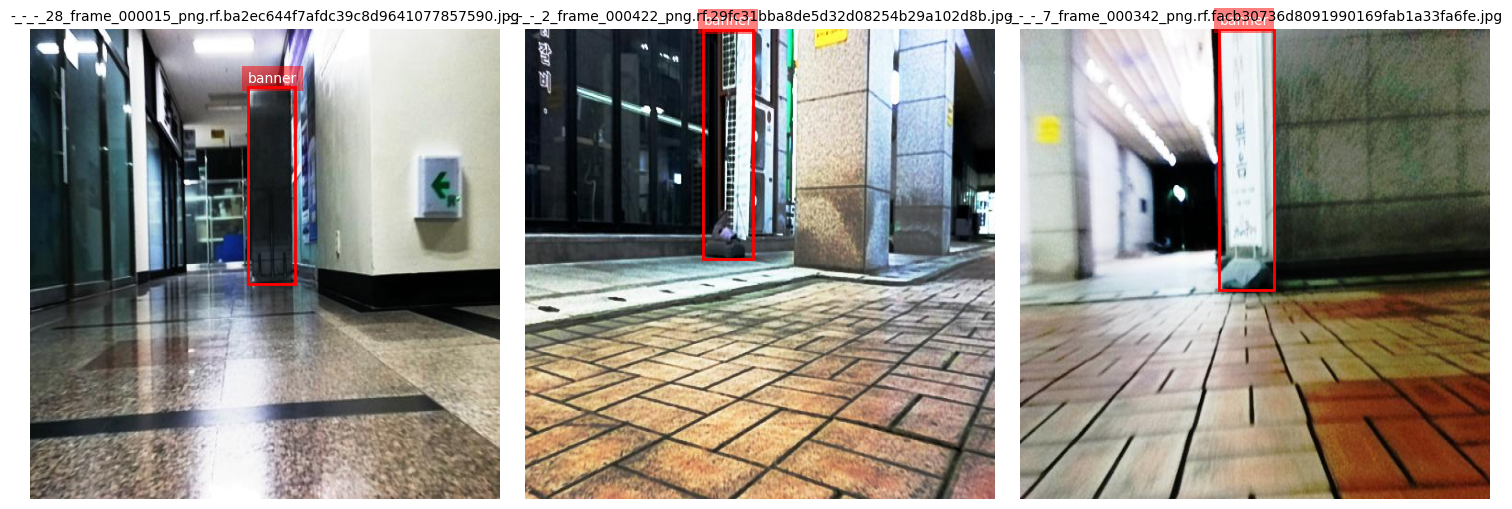

   -> Showing 3 samples for 'val'...


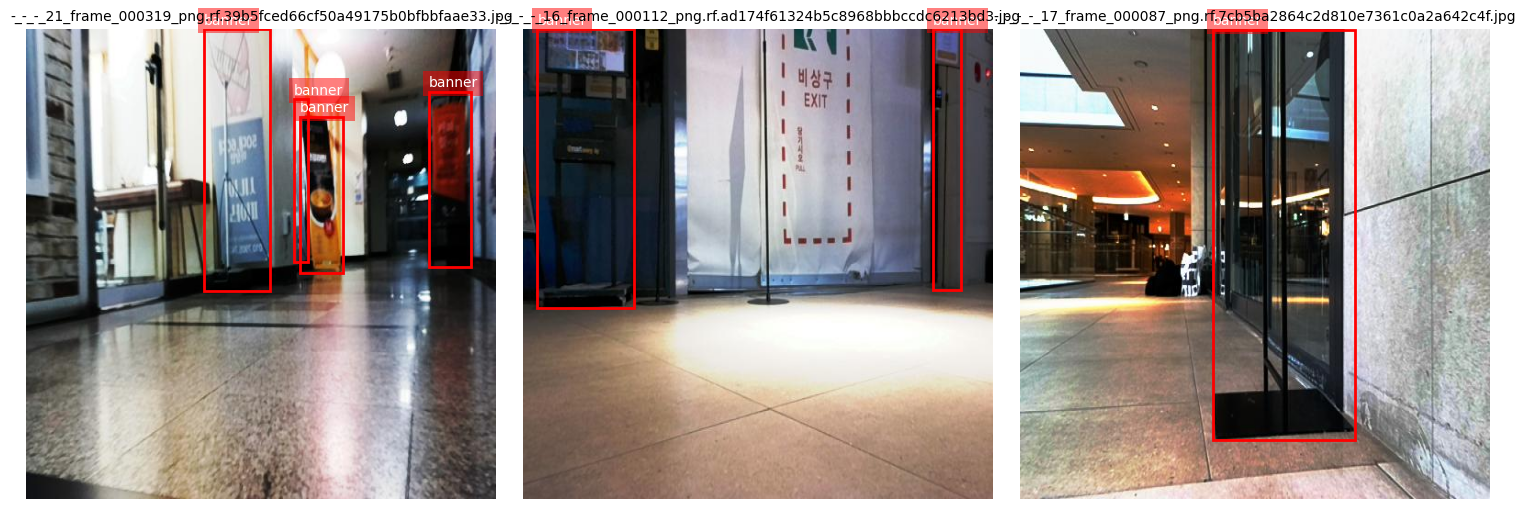

   -> Showing 3 samples for 'test'...


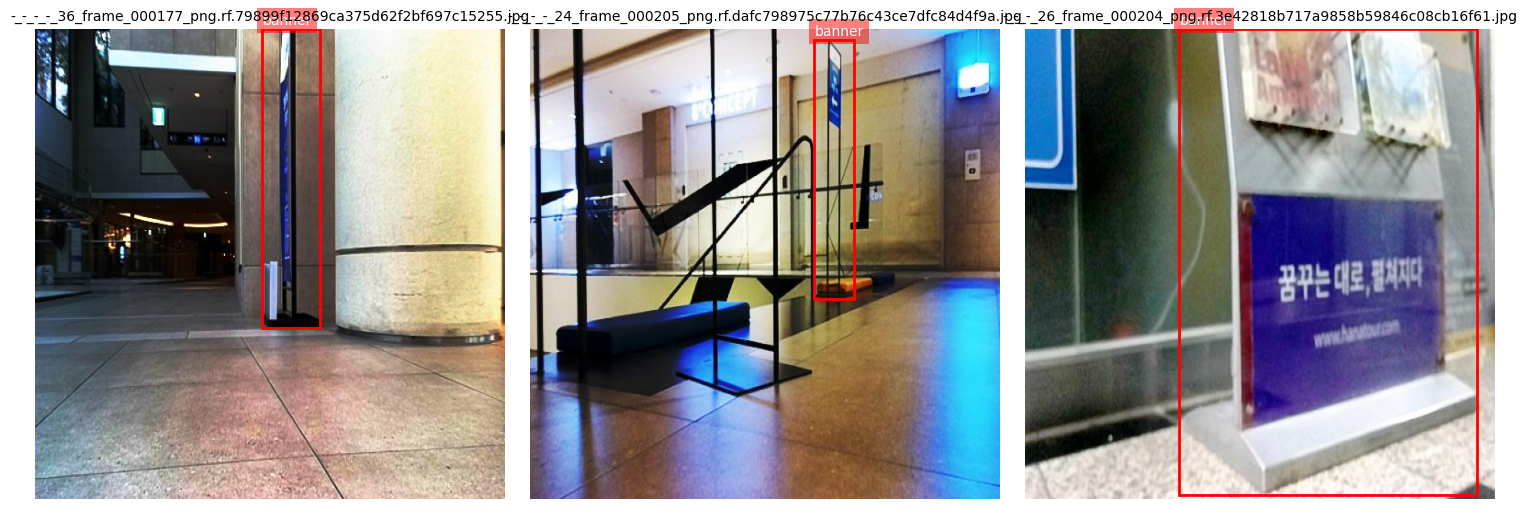

In [ ]:
# Automatically find the data.yaml inside the downloaded folder
target_yaml = os.path.join(dataset.location, "data.yaml")

if os.path.exists(target_yaml):
    print("\n🎨 Starting Visualization...")
    # Change num_samples to see more or fewer images per split
    visualize_dataset(target_yaml, num_samples=3)
else:
    print(f"❌ Could not find data.yaml at {target_yaml}")
